**Install Libraries**

In [118]:
!pip install pyreadstat gdown

**Import packages**

In [158]:
import gdown
import pyreadstat

import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import shapiro

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import roc_auc_score

# **1. Data download and Preparation**

## **1.1. Data download**

In [ ]:
# Download learning dataset
url='https://drive.google.com/file/d/1L_wmWpsaEAiChrb16HlBWOylGTy6GWbT/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
output = 'file.sav'
gdown.download(url, output, quiet=False)

# Download deployment dataset
url='https://drive.google.com/file/d/1tA0j7Yp-7N7U7bCNIUafFc2O-oIIZYAO/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
output_base = 'base.sav'
gdown.download(url, output_base, quiet=False)

# Load both datasets
df, meta = pyreadstat.read_sav('file.sav')
df_base, meta_base = pyreadstat.read_sav('base.sav')
df.head()

Downloading...
From: https://drive.google.com/uc?id=1L_wmWpsaEAiChrb16HlBWOylGTy6GWbT
To: /content/file.sav
100%|██████████| 89.0k/89.0k [00:00<00:00, 54.9MB/s]


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp1,AcceptedCmp2,Complain,Response,Wine_buyer,Gold_buyer
0,210.0,1957.0,Graduation,Single,58138.0,0.0,0.0,1.356610e+10,58.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,692.0,1954.0,Graduation,Single,46344.0,1.0,1.0,1.361362e+10,38.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,723.0,1965.0,Graduation,Together,71613.0,0.0,0.0,1.359642e+10,26.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,716.0,1984.0,Graduation,Together,26646.0,1.0,0.0,1.361137e+10,26.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1149.0,1981.0,PhD,Married,58293.0,1.0,0.0,1.360947e+10,94.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **1.2 Data Preparation**

In [121]:
#integers
df[["ID", "Year_Birth", "Kidhome", "Teenhome", "Recency", "NumWebVisitsMonth", "AcceptedCmp3",	"AcceptedCmp1",	"AcceptedCmp2",	"Complain",	"Response",	"Wine_buyer",	"Gold_buyer"]] = df[["ID", "Year_Birth", "Kidhome", "Teenhome", "Recency", "NumWebVisitsMonth", "AcceptedCmp3",	"AcceptedCmp1",	"AcceptedCmp2",	"Complain",	"Response",	"Wine_buyer",	"Gold_buyer"]].astype("int")

#date
#SPSS stores date‐time values as the number of seconds since October 14, 1582 (its “epoch”),
# while pandas’ datetime conversion assumes Unix time (seconds since January 1, 1970)

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'] - 12219379200, unit='s')

# Calculate membership duration in days, this majes the Dt_Customer date useful to us
df['Membership_Duration_Days'] = (pd.Timestamp.today() - df['Dt_Customer']).dt.days

df = df.drop(columns=['Dt_Customer'])

df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp1,AcceptedCmp2,Complain,Response,Wine_buyer,Gold_buyer,Membership_Duration_Days
0,210,1957,Graduation,Single,58138.0,0,0,58,7,0,0,0,0,1,1,1,4587
1,692,1954,Graduation,Single,46344.0,1,1,38,5,0,0,0,0,0,0,0,4037
2,723,1965,Graduation,Together,71613.0,0,0,26,4,0,0,0,0,0,1,1,4236
3,716,1984,Graduation,Together,26646.0,1,0,26,6,0,0,0,0,0,0,0,4063
4,1149,1981,PhD,Married,58293.0,1,0,94,5,0,0,0,0,0,0,0,4085


## **1.3. Missing Values**

### **Checking for missing values**

In [126]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
missing_values_percentage = (missing_values / len(df)) * 100  # Convert to percentage

# Display missing values and their percentage
missing_analysis = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_values_percentage
})

print(missing_analysis)

Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []


### **handling the missing values**

In [125]:
# Check normality using Shapiro-Wilk test
def check_normality(data):
    stat, p_value = shapiro(data.dropna())  # Drop NaN values before performing the test
    print('Shapiro-Wilk Test Statistic:', stat)
    print('p-value:', p_value)
    # If p-value > 0.05, we assume the data is normally distributed
    if p_value > 0.05:
        print("Data is normally distributed.")
        return True
    else:
        print("Data is not normally distributed.")
        return False

# Check skewness
def check_skewness(data):
    skewness = data.skew()
    print('Skewness:', skewness)
    if skewness > 1 or skewness < -1:
        print("Data is skewed.")
        return True
    else:
        print("Data is approximately symmetric.")
        return False

# Assuming df is your dataframe
if check_normality(df['Income']):
    # If normally distributed, use mean to fill NaN
    df['Income'] = df['Income'].fillna(df['Income'].mean())  # Avoid inplace=True
else:
    # If not normally distributed, use median to fill NaN
    df['Income'] = df['Income'].fillna(df['Income'].median())  # Avoid inplace=True

# Alternatively, you can also fill missing values based on skewness
if check_skewness(df['Income']):
    df['Income'] = df['Income'].fillna(df['Income'].median())  # Avoid inplace=True
else:
    df['Income'] = df['Income'].fillna(df['Income'].mean())  # Avoid inplace=True

# Check the result
print(df['Income'].isnull().sum())


Shapiro-Wilk Test Statistic: 0.9754453530889793
p-value: 9.586062250346682e-14
Data is not normally distributed.
Skewness: 0.3761407017338494
Data is approximately symmetric.
0


# **2. Understand the data**

## **2.1. Describe the data distributions: continuous and categorical variables Descriptive Stats**

In [127]:
#describe the data distributions: continuous and categorical variables Descriptive Stats
#continuous variables
print("\nContinuous Variables:\n")
print(df.drop(columns=["ID"]).describe().to_string())

#categorical variables
print("\nCategorical Variables:\n")
print(df.select_dtypes(include=['object']).describe().to_string())


Continuous Variables:

        Year_Birth         Income      Kidhome     Teenhome      Recency  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp1  AcceptedCmp2     Complain     Response   Wine_buyer   Gold_buyer  Membership_Duration_Days
count  1250.000000    1250.000000  1250.000000  1250.000000  1250.000000        1250.000000   1250.000000   1250.000000    1250.00000  1250.000000  1250.000000  1250.000000  1250.000000               1250.000000
mean   1968.592800   51855.574400     0.442400     0.501600    48.916000           5.304800      0.073600      0.067200       0.01360     0.011200     0.140800     0.402400     0.372800               4277.405600
std      12.116982   21440.893087     0.543064     0.544642    29.257015           2.436195      0.261223      0.250468       0.11587     0.105278     0.347954     0.490578     0.483743                200.102086
min    1893.000000    1730.000000     0.000000     0.000000     0.000000           0.000000      0.000000      0.000000       0.

## **2.2. Describe the kind of relation of all the variables with the 2 target variables and evaluate their predictive powers if any on target variables**

### **Encoding Categorical Values**

In [128]:
# unique values in categorical columns
Education_unq = df['Education'].unique()
Marital_unq = df['Marital_Status'].unique()

print("Education: ", Education_unq)
print("for education there is an order so we will use ordinal encoding\n")
print("Marital_Status: ", Marital_unq)
print("for marital status there is no order so we will use one hot encoding")


Education:  ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
for education there is an order so we will use ordinal encoding

Marital_Status:  ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone']
for marital status there is no order so we will use one hot encoding


In [129]:
# Define the ordinal mapping for Education
education_mapping = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}

# Apply ordinal encoding
df['Education'] = df['Education'].map(education_mapping)

# Apply one-hot encoding for Marital Status and ensure integer dtype
df = pd.get_dummies(df, columns=['Marital_Status'], prefix='Marital').astype(int)

df.head()


,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Recency,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp1,...,Response,Wine_buyer,Gold_buyer,Membership_Duration_Days,Marital_Alone,Marital_Divorced,Marital_Married,Marital_Single,Marital_Together,Marital_Widow
0,210,1957,2,58138,0,0,58,7,0,0,...,1,1,1,4587,0,0,0,1,0,0
1,692,1954,2,46344,1,1,38,5,0,0,...,0,0,0,4037,0,0,0,1,0,0
2,723,1965,2,71613,0,0,26,4,0,0,...,0,1,1,4236,0,0,0,0,1,0
3,716,1984,2,26646,1,0,26,6,0,0,...,0,0,0,4063,0,0,0,0,1,0
4,1149,1981,4,58293,1,0,94,5,0,0,...,0,0,0,4085,0,0,1,0,0,0


### **Correaltion Analysis**

In [138]:
# Calculate the correlation matrix
correlation_matrix = df.drop(columns=["ID"]).corr()

# The correlation with the target variables
target_columns = ['Wine_buyer', 'Gold_buyer']  # Replace with your actual target variables
correlation_with_target = correlation_matrix[target_columns]
print(correlation_with_target)

                          Wine_buyer  Gold_buyer
Year_Birth                 -0.176602   -0.101249
Education                   0.150791   -0.091030
Income                      0.668726    0.401856
Kidhome                    -0.506464   -0.390588
Teenhome                    0.029052   -0.017460
Recency                     0.000516    0.012567
NumWebVisitsMonth          -0.366652   -0.233051
AcceptedCmp3                0.018613    0.055138
AcceptedCmp1                0.294510    0.136685
AcceptedCmp2                0.100838    0.009462
Complain                   -0.040827   -0.050610
Response                    0.169686    0.135028
Wine_buyer                  1.000000    0.406477
Gold_buyer                  0.406477    1.000000
Membership_Duration_Days    0.130260    0.172439
Marital_Alone              -0.006908   -0.004003
Marital_Divorced            0.029300   -0.021991
Marital_Married            -0.029344   -0.066010
Marital_Single             -0.037118    0.079374
Marital_Together    

#### **Correlation heatmap**

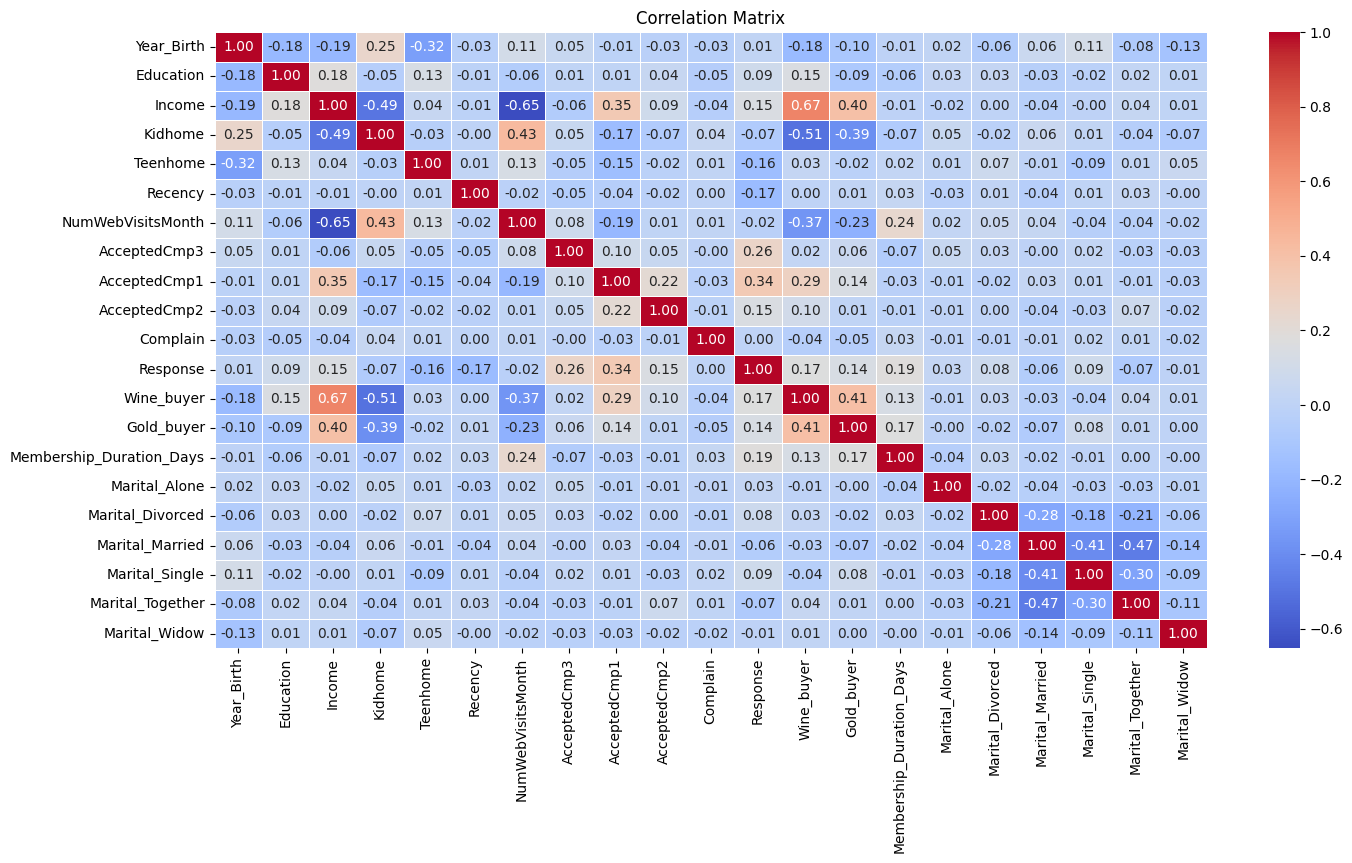

In [139]:
# Calculate the correlation matrix
correlation_matrix = df.drop(columns=["ID"]).corr()

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### **2.3. Crosstabulate Y (in column) with all the explanatory variables Xj (in rows)**

#### **Wine Buyer**

In [145]:
# List of all explanatory variables (columns in the DataFrame that are not the target)
explanatory_vars = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'Complain', 'Education',
                    'Gold_buyer', 'Income', 'Kidhome', 'Marital_Alone', 'Marital_Divorced',
                    'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow',
                    'Membership_Duration_Days', 'NumWebVisitsMonth', 'Recency', 'Response',
                    'Teenhome', 'Year_Birth']

# Prepare a list to store the results
results = []

# Loop through each explanatory variable
for var in explanatory_vars:
    # Crosstab between the explanatory variable and the target variable 'Wine_buyer'
    crosstab = pd.crosstab(df[var], df['Wine_buyer'])

    # Compute the proportion of Wine buyers (1) in each group
    crosstab['Proportion_1'] = crosstab[1] / crosstab.sum(axis=1)

    # Perform Chi-Square test to check if there's a significant relationship
    chi2, p_value, _, _ = stats.chi2_contingency(crosstab)

    # Add the interpretation based on p-value
    if p_value < 0.05:
        interpretation = "There is a significant association"
    else:
        interpretation = "No significant association"

    # Add the result to the list
    results.append({
        'Explanatory Variable': var,
        'Wine Buyer = 0': crosstab[0].sum(),   # Total count for Wine_buyer = 0
        'Wine Buyer = 1': crosstab[1].sum(),   # Total count for Wine_buyer = 1
        'Proportion of Wine Buyers (1)': crosstab[1].sum() / crosstab.sum().sum(), # Proportion of Wine Buyer = 1
        'Chi-Square Statistic': chi2,
        'p-value': p_value,
        'Interpretation': interpretation  # Adding interpretation
    })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("Wine Buyer:")
results_df

Wine Buyer Cross Tabulation Results:


,Explanatory Variable,Wine Buyer = 0,Wine Buyer = 1,Proportion of Wine Buyers (1),Chi-Square Statistic,p-value,Interpretation
0,AcceptedCmp1,747,503,0.401981,116.215277,5.809961e-26,There is a significant association
1,AcceptedCmp2,747,503,0.402008,50.111205,1.313681e-11,There is a significant association
2,AcceptedCmp3,747,503,0.402132,2.870252,2.380854e-01,No significant association
3,Complain,747,503,0.402201,8.233853,1.629452e-02,There is a significant association
4,Education,747,503,0.401883,38.059888,7.338901e-06,There is a significant association
5,Gold_buyer,747,503,0.402107,206.957642,1.147411e-45,There is a significant association
6,Income,747,503,0.293717,1718.943913,1.000000e+00,No significant association
7,Kidhome,747,503,0.402136,348.160196,4.377345e-74,There is a significant association
8,Marital_Alone,747,503,0.402163,56.225076,6.178454e-13,There is a significant association
9,Marital_Divorced,747,503,0.402130,2.522299,2.833282e-01,No significant association


#### **Gold Buyer**

In [147]:
# List of all explanatory variables (columns in the DataFrame that are not the target)
explanatory_vars = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'Complain', 'Education',
                    'Gold_buyer', 'Income', 'Kidhome', 'Marital_Alone', 'Marital_Divorced',
                    'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow',
                    'Membership_Duration_Days', 'NumWebVisitsMonth', 'Recency', 'Response',
                    'Teenhome', 'Year_Birth']

# Prepare a list to store the results
results = []

# Loop through each explanatory variable
for var in explanatory_vars:
    # Crosstab between the explanatory variable and the target variable 'Gold_buyer'
    crosstab = pd.crosstab(df[var], df['Gold_buyer'])

    # Compute the proportion of Gold buyers (1) in each group
    crosstab['Proportion_1'] = crosstab[1] / crosstab.sum(axis=1)

    # Perform Chi-Square test to check if there's a significant relationship
    chi2, p_value, _, _ = stats.chi2_contingency(crosstab)

    # Add the interpretation based on p-value
    if p_value < 0.05:
        interpretation = "Significant association"
    else:
        interpretation = "No significant association"

    # Add the result to the list
    results.append({
        'Explanatory Variable': var,
        'Gold Buyer = 0': crosstab[0].sum(),   # Total count for Gold_buyer = 0
        'Gold Buyer = 1': crosstab[1].sum(),   # Total count for Gold_buyer = 1
        'Proportion of Gold Buyers (1)': crosstab[1].sum() / crosstab.sum().sum(), # Proportion of Gold Buyer = 1
        'Chi-Square Statistic': chi2,
        'p-value': p_value,
        'Interpretation': interpretation  # Adding interpretation
    })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("Gold Buyer:")
results_df

Gold Buyer:


,Explanatory Variable,Gold Buyer = 0,Gold Buyer = 1,Proportion of Gold Buyers (1),Chi-Square Statistic,p-value,Interpretation
0,AcceptedCmp1,784,466,0.372510,28.196319,7.537843e-07,Significant association
1,AcceptedCmp2,784,466,0.372566,15.048780,5.397579e-04,Significant association
2,AcceptedCmp3,784,466,0.372552,6.676067,3.550671e-02,Significant association
3,Complain,784,466,0.372645,6.410950,4.053963e-02,Significant association
4,Education,784,466,0.372318,35.235042,2.422693e-05,Significant association
5,Gold_buyer,784,466,0.372502,1251.000000,2.232552e-272,Significant association
6,Income,784,466,0.278117,1672.171622,1.000000e+00,No significant association
7,Kidhome,784,466,0.372575,200.088530,3.596164e-42,Significant association
8,Marital_Alone,784,466,0.372589,58.574497,1.908577e-13,Significant association
9,Marital_Divorced,784,466,0.372586,1.562837,4.577562e-01,No significant association


### **2.4. Logistic Regression, K-NN, and Naive Bayes: Training and Their Performance**

In [167]:
# Assuming you have a DataFrame called df
X = df.drop(columns=['Wine_buyer', 'Gold_buyer'])  # Features (exclude target columns)
y_SW1 = df['Wine_buyer']  # Target variable SW1
y_SG1 = df['Gold_buyer']  # Target variable SG1

# Split data into training and testing sets (using the same X_train, X_test for both targets)
X_train, X_test, y_train_SW1, y_test_SW1 = train_test_split(X, y_SW1, test_size=0.2, random_state=42)
y_train_SG1 = y_SG1.loc[y_train_SW1.index]  # Ensure y_train_SG1 matches the train split of X
y_test_SG1 = y_SG1.loc[y_test_SW1.index]  # Ensure y_test_SG1 matches the test split of X

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)

    return {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
    }

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}

# Train models for SW1 (Wine Buyer) and store them
trained_models = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_SW1)
    trained_models[model_name] = model  # Store trained model

# Evaluate models for SW1
results_SW1 = {
    model_name: evaluate_model(trained_models[model_name], X_train_scaled, y_train_SW1, X_test_scaled, y_test_SW1)
    for model_name in trained_models
}

# Train models for SG1 (Gold Buyer) using the same models and store them
trained_models_SG1 = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_SG1)
    trained_models_SG1[model_name] = model  # Store trained model for SG1

# Evaluate models for SG1
results_SG1 = {
    model_name: evaluate_model(trained_models_SG1[model_name], X_train_scaled, y_train_SG1, X_test_scaled, y_test_SG1)
    for model_name in trained_models_SG1
}

# Combine results into a DataFrame for easy comparison
results_df = pd.DataFrame([
    {"Model": model_name,
     **results_SW1[model_name],
     **results_SG1[model_name]}
    for model_name in models.keys()
])

# Rename columns for clarity
results_df.rename(columns={
    "Precision": "SW1 Precision", "Recall": "SW1 Recall", "F1 Score": "SW1 F1 Score", "Accuracy": "SW1 Accuracy",
    "SW1 Precision": "SG1 Precision", "SW1 Recall": "SG1 Recall", "SW1 F1 Score": "SG1 F1 Score", "SW1 Accuracy": "SG1 Accuracy",
}, inplace=True)

# Display results
print(results_df)


                 Model  SW1 Precision  SW1 Recall  SW1 F1 Score  SW1 Accuracy
0  Logistic Regression       0.637363    0.666667      0.651685         0.752
1  K-Nearest Neighbors       0.610000    0.701149      0.652406         0.740
2          Naive Bayes       0.568627    0.666667      0.613757         0.708


### **2.5 : Calculate the AUC for each of the above model**

In [170]:
# Function to calculate AUC
def calculate_auc(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)
    return roc_auc_score(y_test, y_prob)

# Calculate AUC for models trained on SW1 (Wine Buyer)
auc_SW1 = {
    model_name: calculate_auc(trained_models[model_name], X_test_scaled, y_test_SW1)
    for model_name in trained_models
}

# Calculate AUC for models trained on SG1 (Gold Buyer)
auc_SG1 = {
    model_name: calculate_auc(trained_models_SG1[model_name], X_test_scaled, y_test_SG1)
    for model_name in trained_models_SG1
}

# Add AUC to the results DataFrame
for model_name in models.keys():
    results_df.loc[results_df['Model'] == model_name, 'SW1 AUC'] = auc_SW1[model_name]
    results_df.loc[results_df['Model'] == model_name, 'SG1 AUC'] = auc_SG1[model_name]

# Display results with AUC included
results_df


,Model,SW1 Precision,SW1 Recall,SW1 F1 Score,SW1 Accuracy,SW1 AUC,SG1 AUC
0,Logistic Regression,0.637363,0.666667,0.651685,0.752,0.832174,0.822862
1,K-Nearest Neighbors,0.610000,0.701149,0.652406,0.740,0.784063,0.788908
2,Naive Bayes,0.568627,0.666667,0.613757,0.708,0.864839,0.787603


**Next Steps & Possible Improvements:**

*   For SW1 (Wine Buyer):

Logistic Regression is already very strong (0.931), but if you want a minor boost, you could try feature selection or hyperparameter tuning.

*   For SG1 (Gold Buyer):

Since no model exceeds 0.823, consider engineering new features, tuning hyperparameters, or even trying Random Forest or XGBoost, which might work better for this class.

### **2.6. Deployment**